In [94]:
# auto reload
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr

from compute_transition import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


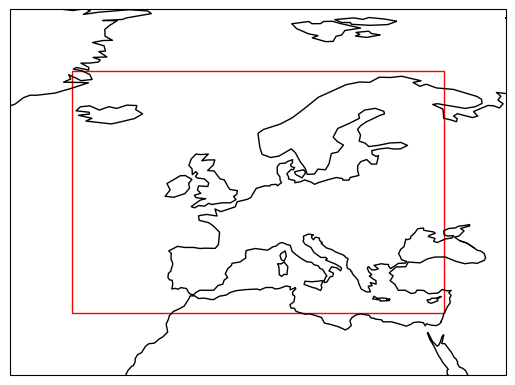

In [95]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
ax.coastlines()
domain = [-25, 35, 33, 72]
ax.add_patch(plt.Rectangle((domain[0], domain[2]), domain[1]-domain[0], domain[3]-domain[2], fill=False, edgecolor="red", transform=ccrs.PlateCarree()))
# add padding to the domain
padding = 10
extent = [domain[0]-padding, domain[1]+padding, domain[2]-padding, domain[3]+padding]
ax.set_extent(extent, crs=ccrs.PlateCarree())

In [96]:
zfile = xr.open_dataset("/home/kbrennan/data/era5/cdf/2024/09/Z20240914_20")

# only keep U and V
zfile = zfile[["U", "V"]]
# crop to the domain
zfile = zfile.sel(lon=slice(extent[0], extent[1]), lat=slice(extent[2], extent[3]))
# only keep 50000 to 90000 Pa
zfile = zfile.sel(plev=slice(50000, 90000))
zfile = zfile.squeeze()

In [97]:
zfile

<xarray.Dataset> Size: 921kB
Dimensions:  (plev: 6, lat: 119, lon: 161)
Coordinates:
  * lon      (lon) float32 644B -35.0 -34.5 -34.0 -33.5 ... 43.5 44.0 44.5 45.0
  * lat      (lat) float32 476B 23.0 23.5 24.0 24.5 25.0 ... 80.5 81.0 81.5 82.0
  * plev     (plev) float64 48B 5e+04 6e+04 7e+04 8e+04 8.5e+04 9e+04
    time     datetime64[ns] 8B 2024-09-14T20:00:00
Data variables:
    U        (plev, lat, lon) float32 460kB ...
    V        (plev, lat, lon) float32 460kB ...
Attributes:
    CDI:          Climate Data Interface version 1.8.2 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Sat Jan 11 14:52:04 2025: cdo -b F32 -f nc4c -z zip -t ecmw...
    institution:  European Centre for Medium-Range Weather Forecasts
    CDO:          Climate Data Operators version 1.8.2 (http://mpimet.mpg.de/...

In [98]:
# compute the transition matrix
transition_matrix = compute_transition_indices(zfile,2*3600)

Text(0.5, 1.0, 'Histogram of Transition Distances')

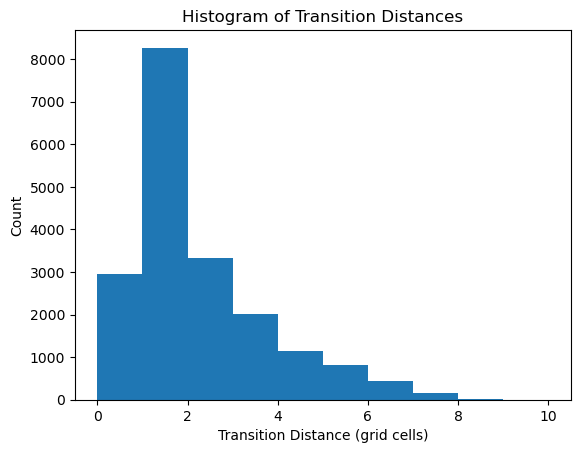

In [ ]:
# histogram transition index distance (use xarray Dataset)

distances = []
lat_idx = transition_matrix["lat_idx"].values
lon_idx = transition_matrix["lon_idx"].values

# assume dimensions (..., lat, lon); take the last leading index (e.g. surface or selected level)
idx_slice = tuple([ -1 ] * (lat_idx.ndim - 2))  # last index for any leading dims
lat_field = lat_idx[idx_slice]
lon_field = lon_idx[idx_slice]

nlat, nlon = lat_field.shape
for i in range(nlat):
    for j in range(nlon):
        distances.append(np.sqrt((lat_field[i, j] - i) ** 2 + (lon_field[i, j] - j) ** 2))

plt.hist(distances, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.xlabel("Transition Distance (grid cells)")
plt.ylabel("Count")
plt.title("Histogram of Transition Distances")

Text(0.5, 1.0, 'Transition Vectors (indices)')

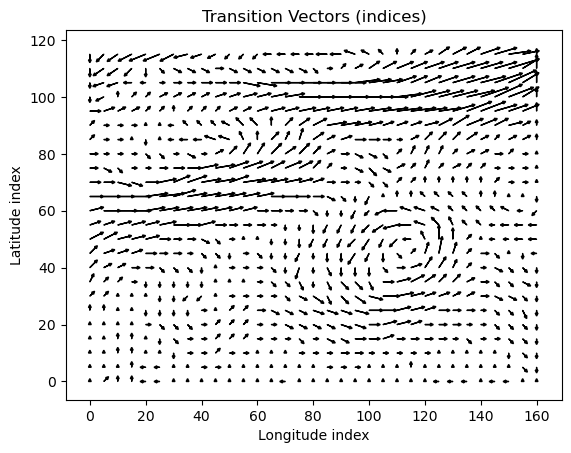

In [ ]:
fig, ax = plt.subplots()

i_plev = 0
skip = 5

lat_idx = transition_matrix["lat_idx"].values
lon_idx = transition_matrix["lon_idx"].values

# select given level (or last leading index if multiple)

if lat_idx.ndim > 2:
    lat_field = lat_idx[i_plev]
    lon_field = lon_idx[i_plev]

else:
    lat_field = lat_idx
    lon_field = lon_idx

nlat, nlon = lat_field.shape
for i in range(0, nlat, skip):
    for j in range(0, nlon, skip):
        ax.arrow(
            j,
            i,
            lon_field[i, j] - j,
            lat_field[i, j] - i,
            head_width=1,
            head_length=1,
            fc="k",
            ec="k",
        )

ax.set_xlabel("Longitude index")
ax.set_ylabel("Latitude index")
ax.set_title("Transition Vectors (indices)")